# Анализ рынка заведений общественного питания г.Москвы
**Цель проекта**: исследовать рынок заведений общественного питания для дальнейшего открытия заведения.

**Задачи проекта**:
- Исследовать существующие виды общественного питания, их распространненость;
- Изучить сетевые заведения города;
- Определить, какие районы наиболее выгодны для открытия заведения;
- Выявить, сколько посадочных мест является оптимальным.

Для реализации проекта будут использованы:  открытые данные о заведениях общественного питания в Москве и инструменты Python.

**Этапы исследования**:
1. [Подготовка данных](#preanalysis)
2. [Анализ данных](#analysis)
    - [Исследование видов объектов общественного питания](#type_object)
    - [Исследование сетевых и несетевых заведений](#chain)
    - [Изучение наиболее популярных улиц для заведений](#popular_street)
    - [Анализ наименее популярных районов для заведений](#unpopular_street)
    - [Изучение количества посадочных мест заведения на популярных улицах](#number_popular_street)
3. [Вывод и рекомендации](#conclusion)

## [Подготовка данных](#preanalysis)

На этапе подготовки данных импортируем все необходимые для реализации проекта библиотеки и откроем данные таблиц, чтобы оценить, какие изменения в данных нужно сделать.

In [ ]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import datetime as dt
from plotly import graph_objects as go
import plotly.express as px
import requests

In [ ]:
try:
    rest_data = pd.read_csv('/content/rest_data.csv')
except:
    rest_data = pd.read_csv('/datasets/rest_data.csv')
rest_data.info()
rest_data.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15366 entries, 0 to 15365
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           15366 non-null  int64 
 1   object_name  15366 non-null  object
 2   chain        15366 non-null  object
 3   object_type  15366 non-null  object
 4   address      15366 non-null  object
 5   number       15366 non-null  int64 
dtypes: int64(2), object(4)
memory usage: 720.4+ KB


,id,object_name,chain,object_type,address,number
0,151635,СМЕТАНА,нет,кафе,"город Москва, улица Егора Абакумова, дом 9",48
1,77874,Родник,нет,кафе,"город Москва, улица Талалихина, дом 2/1, корпус 1",35
2,24309,Кафе «Академия»,нет,кафе,"город Москва, Абельмановская улица, дом 6",95
3,21894,ПИЦЦЕТОРИЯ,да,кафе,"город Москва, Абрамцевская улица, дом 1",40
4,119365,Кафе «Вишневая метель»,нет,кафе,"город Москва, Абрамцевская улица, дом 9, корпус 1",50
5,27429,СТОЛ. ПРИ ГОУ СОШ № 1051,нет,столовая,"город Москва, Абрамцевская улица, дом 15, корп...",240
6,148815,Брусника,да,кафе,"город Москва, переулок Сивцев Вражек, дом 6/2",10
7,20957,Буфет МТУСИ,нет,столовая,"город Москва, Авиамоторная улица, дом 8, строе...",90
8,20958,КПФ СЕМЬЯ-1,нет,столовая,"город Москва, Авиамоторная улица, дом 8, строе...",150
9,28858,Столовая МТУСИ,нет,столовая,"город Москва, Авиамоторная улица, дом 8, строе...",120


Явных пропусков в данных нет. Посмотрим детально корректность значений по столбцам. В названии заведений нужно будет поменять регистр и привести их к общему виду, а также в названии типа заведения и адресе. Помимо этого посмотрим уникальные значения столбцов, чтобы выявить неточности.

In [ ]:
rest_data['chain'].unique()


array(['нет', 'да'], dtype=object)

In [ ]:
rest_data['number'].unique()

array([  48,   35,   95,   40,   50,  240,   10,   90,  150,  120,    5,
         24,  140,   32,  270,  320,    7,    2,  160,   20,   30,  110,
          6,  192,   65,   45,    4,  125,  100,   49,   63,   70,   22,
         56,   38,  220,   78,    3,   80,   46,   15,   96,   60,   47,
        180,  250,  200,   25,   12,   14,   16,  420,   98,   75,   34,
        216,   43,   54,  580,  159,    0,   28,   64,   67,   42,  124,
         82,   36,  114,    8,   71,   18,  158,   55,  196,   44,   76,
        144,   41,   26,   68,  143,  198,   79,    1,   86,  148,  190,
        202,  131,   52,   92,  300,   85,  102,   88,   84,  246,   81,
         94,   23,   37,   39,   99,   61,   11,  130,   74,  128,  106,
         58,  260,   27,   19,   29,   13,    9,  168,  350,   93,   33,
        105,  239,  104,   17,   62,  230,  132,   87,   89,  170,   83,
         21,  108,  210,   51,   53,  115,   66,  280,  126,   97,  356,
        156,  428,  380,  138,   72,  118,  139,  2

In [ ]:
rest_data['object_type'].unique()

array(['кафе', 'столовая', 'закусочная',
       'предприятие быстрого обслуживания', 'ресторан', 'кафетерий',
       'буфет', 'бар', 'магазин (отдел кулинарии)'], dtype=object)

In [ ]:
rest_data['object_type'].value_counts()

кафе                                 6099
столовая                             2587
ресторан                             2285
предприятие быстрого обслуживания    1923
бар                                   856
буфет                                 585
кафетерий                             398
закусочная                            360
магазин (отдел кулинарии)             273
Name: object_type, dtype: int64

In [ ]:
rest_data['object_type'] = rest_data['object_type'].str.replace('предприятие быстрого обслуживания', 'фаст-фуд')
rest_data['object_type'] = rest_data['object_type'].str.replace('магазин \(отдел кулинарии\)', 'кулинария')

In [ ]:
#приведем данные столбца с названиями заведений к нижнему регистру и проверим наличие дубликатов
rest_data['object_name'] = rest_data['object_name'].str.lower()
rest_data['object_name'] = rest_data['object_name'].str.replace('ё','е')

#избавимся от типа заведения в названии
for type_rest in ['кафе', 'бар', 'кальянная', 'ресторан', 'буфет', 'столовая', 'хинкальная']:
    rest_data['object_name'] = rest_data['object_name'].str.replace(type_rest,'', regex=True).str.strip()

rest_data['object_name'] = rest_data['object_name'].str.replace("«",'', regex=True).str.strip()
rest_data['object_name'] = rest_data['object_name'].str.replace("»",'', regex=True).str.strip()
rest_data['object_name'] = rest_data['object_name'].str.replace("-",'', regex=True).str.strip()

rest_data['object_name'].unique()

array(['сметана', 'родник', 'академия', ..., 'магазин готовой еды милти',
       'лаундж мята lounge', 'мята lounge октябрьская'], dtype=object)

In [ ]:
rest_data['address'] = rest_data['address'].str.replace('ё','е')
rest_data['address'] = rest_data['address'].str.lower()

In [ ]:
rest_data.duplicated().sum()

0

В ходе подготовки данных к анализу данные были приведены к общему виду для повышения точности исследования.

## [Анализ данных](#analysis)
**[Исследование видов объектов общественного питания](#type_objec)**

На этом этапе проведем анализ заведений, отталкиваясь от того, к какому виду они относятся. В начале проанализируем соотношение видов объектов общественного питания по количеству заведений.

In [ ]:
object_type_count = pd.DataFrame(rest_data.groupby('object_type')['id'].count()).reset_index().sort_values(by='id', ascending=False)
object_type_count

,object_type,id
3,кафе,6099
7,столовая,2587
6,ресторан,2285
8,фаст-фуд,1923
0,бар,856
1,буфет,585
4,кафетерий,398
2,закусочная,360
5,кулинария,273


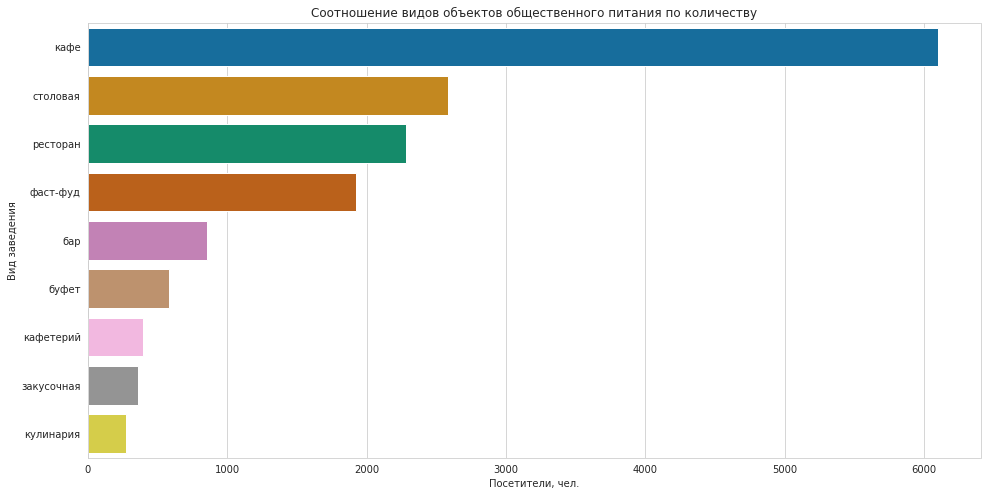

In [ ]:
plt.figure(figsize=(16,8))
sns.set_palette('colorblind') 
sns.set_style("whitegrid")
ax = sns.barplot(data=object_type_count, x="id", y="object_type", estimator=np.mean)
ax.set_title("Соотношение видов объектов общественного питания по количеству")
ax.set_ylabel("Вид заведения")
ax.set_xlabel("Посетители, чел.")
plt.show()
plt.close()

Больше всего в Москве кафе, столовых, ресторанов и фаст-фуда. Кафе лидируют, скорее всего, за счет своей доступности: не очень высокий средний чек, комфортный уровень обслуживания. Кулинарии и закусочных почти нет. Возможно это связано с интрепретацией данных, т.к. вид заведения может быть определен не совсем кореектно. Псомотрим, как меняется среднее количество посадочных мест в зависимости от типа заведения.

In [ ]:
rest_data['number'].describe()

count    15366.000000
mean        59.547182
std         74.736833
min          0.000000
25%         12.000000
50%         40.000000
75%         80.000000
max       1700.000000
Name: number, dtype: float64

График среднего значения будем строить по медианным данным, т.к. могут быть искажения за счет большого разброса между минимальным и максимальным значениями.

In [ ]:
object_type_number = pd.DataFrame(rest_data.groupby('object_type')['number'].median()).reset_index()
object_type_number

,object_type,number
0,бар,35
1,буфет,32
2,закусочная,0
3,кафе,30
4,кафетерий,6
5,кулинария,0
6,ресторан,80
7,столовая,103
8,фаст-фуд,5


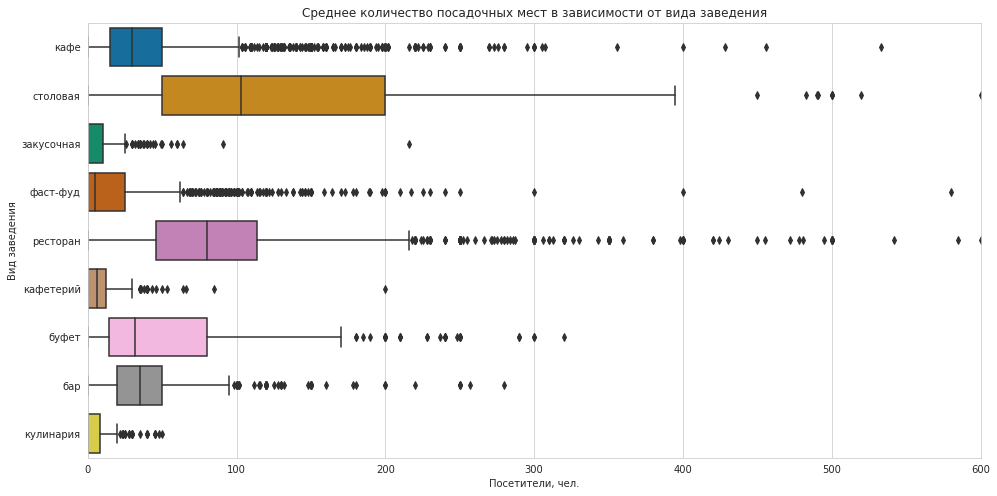

In [ ]:
plt.figure(figsize=(16,8))
sns.set_palette('colorblind') 
sns.set_style("whitegrid")
ax = sns.boxplot(data=rest_data, x="number", y="object_type")
ax.set_title("Среднее количество посадочных мест в зависимости от вида заведения")
ax.set_xlim(0,600)
ax.set_ylabel("Вид заведения")
ax.set_xlabel("Посетители, чел.")
plt.show()
plt.close()

В среднем самое большое количество посадочных мест в столовых и ресторанах. Столовые рассчитаны на большое количество посетителей, часто они находятся при каких-то организациях, откуда много сотрудников идут на обед именно в столовую. Рестораны славятся не только едой, но и интерьером, поэтому их часто тоже делают в больших помещениях + немаловажный фактор что часто в ресторанах и столовых проводят мероприятия. Меньше всего вероятность найти место - в заведениях фаст-фуда и кафетерии. Данных по местам в кулинарии и закусочной нет.

**[Исследование сетевых и несетевых заведений](#chain)**

Заведения общественного питания делятся на сетевых и несетевые. Посмотрим, как распределилось соотношение сетевых и несетевых заведений по количеству заведений в городе. 

In [ ]:
chain_type_count = pd.DataFrame(rest_data.groupby('chain')['id'].count()).reset_index().sort_values(by='id', ascending=False)
chain_type_count

,chain,id
1,нет,12398
0,да,2968


In [ ]:
name_rest = 'Несетевые', 'Сетевые'
values = chain_type_count['id']

fig = go.Figure(data=[go.Pie(labels=name_rest, values=values, pull=[0, 0.2])])
fig.update_traces(textposition='inside')
fig.update(layout_title_text='Соотношение сетевых и несетевых заведений общественного питания', 
           layout_showlegend=True)
fig.show()

Несетевые заведения составляют почти 81% всех заведений города. Сетевые, скорее всего, сложно поддерживать, т.к. зачастую одно сетевое заведение приносит много прибыли, а второе - работает в убыток, за счет чего компания скорее работает в ноль. Посмотрим, где больше посадочных мест: в сетевых или несетвых заведениях и проанализируем сетевые заведения по количеству мест в них.

In [ ]:
chain_type_number = pd.DataFrame(rest_data.groupby('chain')['number'].mean()).reset_index().sort_values(by='number', ascending=False)
chain_type_number

,chain,number
1,нет,61.133731
0,да,52.919811


In [ ]:
name_rest = 'Несетевые', 'Сетевые'
values = chain_type_number['number']

fig = go.Figure(data=[go.Pie(labels=name_rest, values=values)])
fig.update_traces(textposition='inside')
fig.update(layout_title_text='Среднее количество посадочных мест', 
           layout_showlegend=True)
fig.show()

In [ ]:
yes = 'да'
is_chain = rest_data.query('chain == @yes')

is_chain['object_type'].unique().tolist()

['кафе',
 'фаст-фуд',
 'ресторан',
 'кулинария',
 'кафетерий',
 'закусочная',
 'бар',
 'буфет',
 'столовая']

In [ ]:
chain_object = is_chain.groupby('object_type').agg({'number' : 'median', 'id' : 'count'}).sort_values(by='number', ascending=False).reset_index()
chain_object

,object_type,number,id
0,столовая,120.0,3
1,ресторан,88.5,544
2,бар,45.0,37
3,кафе,40.0,1396
4,фаст-фуд,25.0,791
5,закусочная,8.0,56
6,кафетерий,8.0,52
7,кулинария,3.5,78
8,буфет,0.0,11


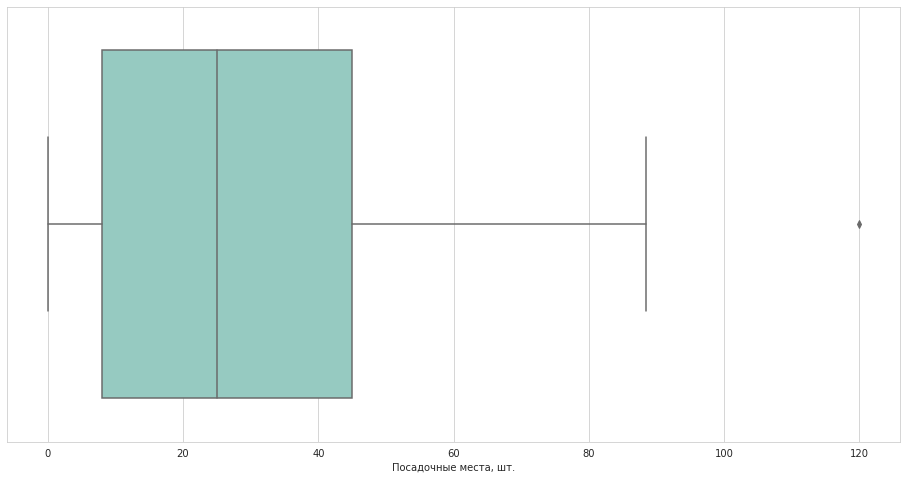

In [ ]:
plt.figure(figsize=(16,8))
sns.set_palette('Set3') 
ax = sns.boxplot(x=chain_object['number'])
ax.set_xlabel("Посадочные места, шт.")
plt.show()
plt.close()

In [ ]:
chain_object['number'].describe()

count      9.000000
mean      37.555556
std       41.726374
min        0.000000
25%        8.000000
50%       25.000000
75%       45.000000
max      120.000000
Name: number, dtype: float64

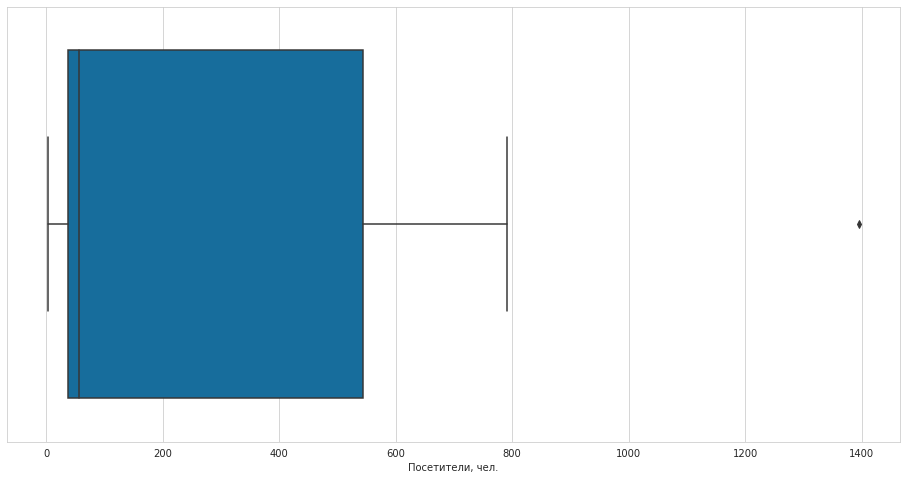

In [ ]:
plt.figure(figsize=(16,8))
sns.set_palette('colorblind') 
ax = sns.boxplot(x=chain_object['id'])
ax.set_xlabel("Посетители, чел.")
plt.show()
plt.close()

In [ ]:
chain_object['id'].describe()

count       9.000000
mean      329.777778
std       487.990209
min         3.000000
25%        37.000000
50%        56.000000
75%       544.000000
max      1396.000000
Name: id, dtype: float64

Для сетевых заведений характерно много заведений с небольшим числом посадочных мест и, соответсвенно, небольшим числом посетителей. Но есть заведения, сильно отклоняющиеся от данной тенденции.

Сетевыми чаще всего являются кафе, фаст-фуд и рестораны.

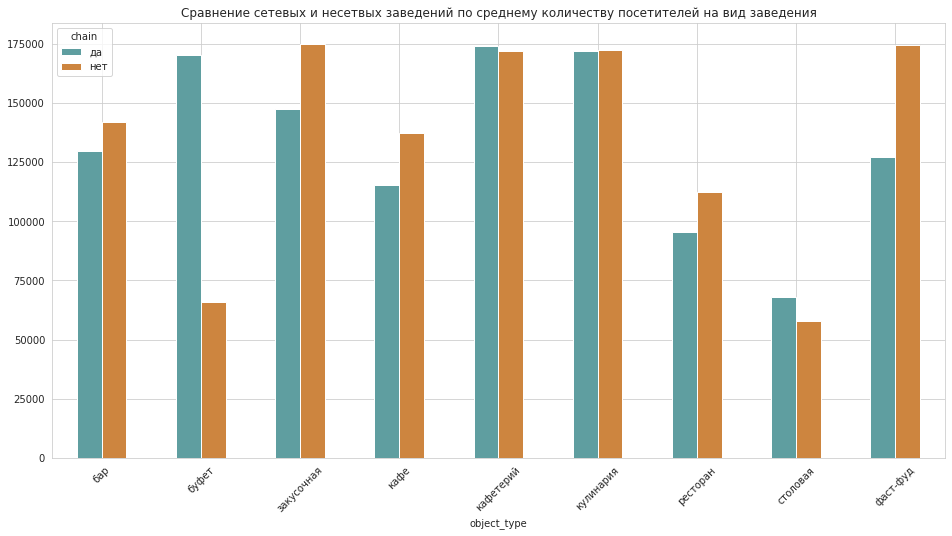

In [ ]:
(rest_data
         .pivot_table(index='object_type', columns = 'chain',values='id', aggfunc='mean')
         .plot(kind='bar', grid=True, figsize=(16,8), rot=45, title='Сравнение сетевых и несетвых заведений по среднему количеству посетителей на вид заведения', color=['cadetblue','peru'])
);

Большая часть заведений общественного питания в Москве - несетевые. Среди несетвых заведений в среднем больше всего посетителей приходится на: закусочные, кафетерии, кулинарии и фаст-фуды. Среди сетевых -буфеты, кафетерии и кулинарии.  

**[Изучение наиболее популярных улиц для заведений](#popular_street)**

На основе имеющихся данных об адресе заведения, выделим 10 наиболее популярных месторасположений, а далее разделим их по районам.

In [ ]:
list = (['город московский', 'поселение мосрентген', 'поселение московский', 'поселение михайлово-ярцевское', 'поселение марушкинское', 'город троицк', 'поселение сосенское', 'город зеленоград'])
def get_street(row):
      if row['address'].split(",")[0].strip() == 'город москва' and row['address'].split(",")[1].strip() not in list:
            return row['address'].split(",")[1].strip()
      elif row['address'].split(",")[1].strip() in list:
            return row['address'].split(",")[2].strip()
      else:
            return row['address'].split(",")[0].strip()
rest_data['street'] = rest_data.apply(get_street, axis=1)
rest_data

,id,object_name,chain,object_type,address,number,street
0,151635,сметана,нет,кафе,"город москва, улица егора абакумова, дом 9",48,улица егора абакумова
1,77874,родник,нет,кафе,"город москва, улица талалихина, дом 2/1, корпус 1",35,улица талалихина
2,24309,академия,нет,кафе,"город москва, абельмановская улица, дом 6",95,абельмановская улица
3,21894,пиццетория,да,кафе,"город москва, абрамцевская улица, дом 1",40,абрамцевская улица
4,119365,вишневая метель,нет,кафе,"город москва, абрамцевская улица, дом 9, корпус 1",50,абрамцевская улица
...,...,...,...,...,...,...,...
15361,208537,шоколадница,да,кафе,"город москва, 3-й крутицкий переулок, дом 18",50,3-й крутицкий переулок
15362,209264,шоколадница,да,кафе,"город москва, улица земляной вал, дом 33",10,улица земляной вал
15363,209186,шоколадница,да,кафе,"город москва, улица земляной вал, дом 33",20,улица земляной вал
15364,221900,шоколадница,да,кафе,"город москва, поселение московский, киевское ш...",36,киевское шоссе


In [ ]:
street_count = rest_data.groupby('street').agg({'id': 'count', 'number' : 'median'}).reset_index().sort_values(by='id', ascending=False)
street_count_head = street_count.head(10)
street_count_head

,street,id,number
1232,проспект мира,204,46.5
1236,профсоюзная улица,183,24.0
835,ленинградский проспект,173,40.0
1187,пресненская набережная,167,30.0
427,варшавское шоссе,162,30.0
838,ленинский проспект,148,45.0
1228,проспект вернадского,132,40.0
826,кутузовский проспект,114,40.0
640,каширское шоссе,112,25.0
649,кировоградская улица,110,30.0


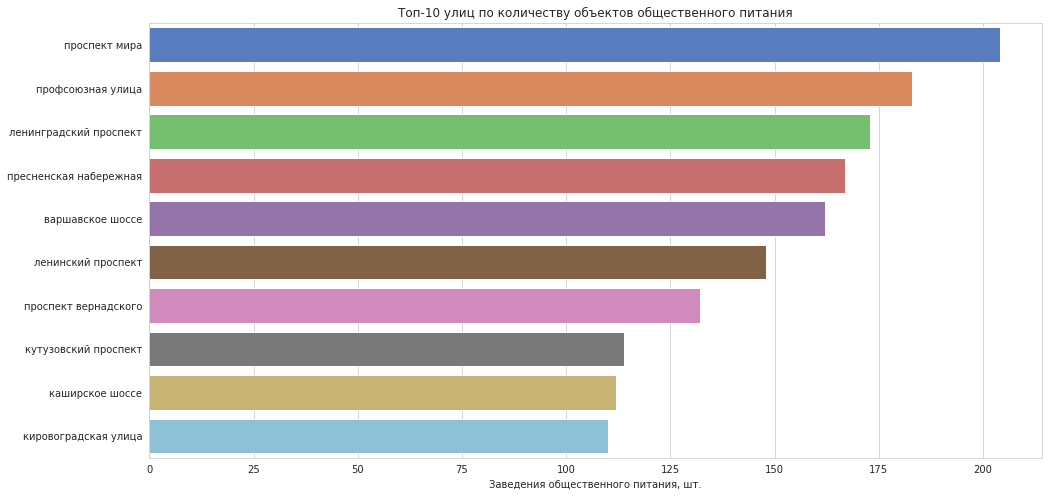

In [ ]:
plt.figure(figsize=(16,8))
sns.set_palette('muted') 
sns.set_style("whitegrid")
ax = sns.barplot(data=street_count_head, y="street", x="id")
ax.set_title("Топ-10 улиц по количеству объектов общественного питания")
ax.set_ylabel("")
ax.set_xlabel("Заведения общественного питания, шт.")
plt.show()
plt.close()

Распределение наиболее густозаселенных заведениями улиц по районам и округам:
* Проспект Мира: СВАО(а именно: Мещанский, Марьина Роща, Алексеевский, Останкинский, Свиблово, Ростокино)
* Профсоюзная улица: ЮЗАО (а именно: Академический, Коньково, Обручевский, Тёплый Стан, Черёмушки, Ясенево)
* Ленинградский проспект: САО (а именно: Беговой, Аэропорт, Сокол, Хорошёвский)
* Пресненская набережная: ЦАО (а именно: Пресненский)
* Варшавское шоссе: ЮЗАО (а именно: Донской, Нагатино-Садовники, Нагорный)
* Ленинский проспект: ЮЗАО (а именно: Гагаринский и Донской)
* Проспект Вернадского: ЗАО (а именно: Проспект Вернадского)
* Кутузовский проспект: ЗАО (а именно: Дорогомилово, Фили-Давыдково)
* Каширское шоссе: ЮАО (а именно: Нагатино-Садовники и Нагорный)
* Кировоградская улица: ЮАО (а именно: Чертаново Северное, Чертаново Центральное и Чертаново Южное)

Наиболее популярные округа для заведений общепита: ЮЗАО, ЗАО, ЮАО, а именно юг оранжевой и серой ветки г. Москвы, не прилегающий к центру города, находятся в 3-4 станциях от кольцевой. То есть чаще открываются заведения в спальных районах, скорее всего в расчете на то, что люди скорее зайдут в ближайшее заведение, чем поедут куда-то далеко.

**[Анализ наименее популярных районов для заведений](#unpopular_street)**

Посмотрим, на каких улицах располагается только одно заведение и изучим, в каких районах располагаются такие заведения.

In [ ]:
unpopular_street = street_count.query('id == "1"')
print('Всего улиц с 1 объектом общественного питания: {}, что составляет {:.1%} от всего кол-ва улиц с объектами общественного питания'\
      .format(len(unpopular_street), (len(unpopular_street)/len(street_count))))

Всего улиц с 1 объектом общественного питания: 652, что составляет 32.1% от всего кол-ва улиц с объектами общественного питания


In [ ]:
from io import BytesIO
import requests
spreadsheet_id = '1gKh1MjZk6oa_b7qggRm9wGai_nLfbDIhDMhwWscqCao'
file_name = 'https://docs.google.com/spreadsheets/d/{}/export?format=csv'.format(spreadsheet_id)
r = requests.get(file_name)
district = pd.read_csv(BytesIO(r.content))
district.head(10)

,streetname,areaid,okrug,area
0,Выставочный переулок,17.0,ЦАО,Пресненский район
1,улица Гашека,17.0,ЦАО,Пресненский район
2,Большая Никитская улица,17.0,ЦАО,Пресненский район
3,Глубокий переулок,17.0,ЦАО,Пресненский район
4,Большой Гнездниковский переулок,17.0,ЦАО,Пресненский район
5,Малый Гнездниковский переулок,17.0,ЦАО,Пресненский район
6,Большая Грузинская улица,17.0,ЦАО,Пресненский район
7,Малая Грузинская улица,17.0,ЦАО,Пресненский район
8,Грузинская площадь,17.0,ЦАО,Пресненский район
9,улица Грузинский Вал,17.0,ЦАО,Пресненский район


In [ ]:
district['streetname'] = district['streetname'].str.lower()
district

,streetname,areaid,okrug,area
0,выставочный переулок,17.0,ЦАО,Пресненский район
1,улица гашека,17.0,ЦАО,Пресненский район
2,большая никитская улица,17.0,ЦАО,Пресненский район
3,глубокий переулок,17.0,ЦАО,Пресненский район
4,большой гнездниковский переулок,17.0,ЦАО,Пресненский район
...,...,...,...,...
4393,вознесенский проезд,17.0,ЦАО,Пресненский район
4394,волков переулок,17.0,ЦАО,Пресненский район
4395,поварская улица,17.0,ЦАО,Пресненский район
4396,кудринская площадь,17.0,ЦАО,Пресненский район


In [ ]:
unpopular_merged = unpopular_street.merge(district[['streetname', 'okrug', 'area']], left_on='street', right_on='streetname')
display(unpopular_merged.groupby('area')['id'].count().reset_index().sort_values(by='id').head(10))

,area,id
52,Район Марьино,1
56,Район Москворечье-Сабурово,1
57,Район Нагатино-Садовники,1
15,Молжаниновский район,1
84,Район Чертаново Северное,1
88,Район Южное Медведково,1
85,Район Чертаново Южное,1
29,Район Восточный,1
50,Район Марфино,1
48,Район Лианозово,1


In [ ]:
display(unpopular_merged.groupby('area')['id'].count().reset_index().sort_values(by='id').tail(10))

,area,id
33,Район Замоскворечье,14
75,Район Сокольники,15
13,Мещанский район,15
22,Район Арбат,18
51,Район Марьина роща,18
95,Тверской район,20
21,Пресненский район,20
3,Басманный район,21
80,Район Хамовники,24
94,Таганский район,27


Всего улиц с 1 объектом общественного питания: 652, что составляет 32.1% от всего кол-ва улиц с объектами общественного питания.

Больше всего улиц с одним объектом общественного питания в центре города: Таганский, Хамовники, Басманный, Пресненский, Тверской. Возможно одна из причин такого распределения - много маленьких улиц в центре. По одному объекту общесвтенного питания было определено в спальных районах, среди них встречаются районы, которые вошли в список наиболее популярных районов, что возможно связано с привязкой улицы к району, где могут быть некоторые неточности.

**[Изучение количества посадочных мест заведения на популярных улицах](#number_popular_street)**

In [ ]:
top10_streets_list = street_count_head['street'].to_list()
top10_streets_data = rest_data.query('street in @top10_streets_list')

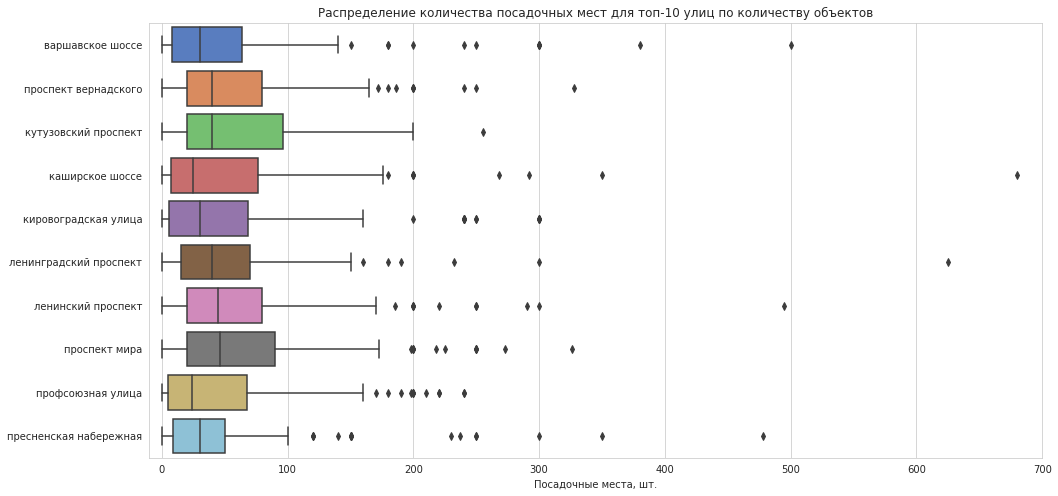

In [ ]:
top10_streets_data['number'].median()
rest_data['number'].median()
plt.figure(figsize=(16,8))
sns.set_palette('muted') 
sns.set_style("whitegrid")
ax = sns.boxplot(data=top10_streets_data, x='number', y='street')
ax.set_xlim(-10,700)
plt.title('Распределение количества посадочных мест для топ-10 улиц по количеству объектов')
plt.ylabel('')
plt.xlabel('Посадочные места, шт.')
plt.show()

В среднем на самых густонаполненных заведениями улицах - 20-50 посадочных мест, а выбросы для каждой улицы начинаются после 150 посадочных мест.

## [Вывод и рекомендации](#conclusion)

* Больше всего в Москве кафе, столовых, ресторанов и фаст-фуда;
* Кулинарии и закусочные наименее популярные виды общепита в Москве;
* В среднем самое большое количество посадочных мест в столовых и ресторанах;
* Зведения фаст-фуда и кафетерии обычно не располагают большим количеством посадочных мест;
* Несетевые заведения составляют почти 81% всех заведений города;
* Для сетевых заведений характерно много заведений с небольшим количеством посадочных мест;
* Сетевыми чаще всего являются кафе, фаст-фуд и рестораны;
* Наиболее популярные районы для заведений общепита:
      - Московский международный деловой центр Москва-Сити;
      - район Чертаново Центральное;
      - район Тропарёво-Никулино;
      - Мещанский район;
      - район Свиблово;
      - район Аэропорт;
      - район Дорогомилово;
      - район Нагатино-Садовники;
      - район Фили-Давыдково;
      - Алексеевский район.
* Наименее популярные районы с большим количеством улиц с одним заведением находятся в основном в центре:
      - Таганский район - 27 улиц с одним объектом;
      - Тверской район - 23 улицы с одним объектом;
      - Басманный район - 23 улицы с одним объектом;
      - район Марьина Роща - 19 улиц с одним объектом;
      - Пресненский район - 17 улиц с одним объектом;
      - район Богородское - 13 улиц с одним объектом;
      - Даниловский район - 12 улиц с один объектом;
      - Мещанский район - 12 улиц с одним объектом;
      - район Замоскворечье - 12 улиц с одним объектом;
      - район Соколиная гора - 11 улиц с одним объектом.
* В среднем в популярных райнах среди заведений находятся заведения с 20-50 посадочными местами.

**На основе полученной информации можно говорить о том, что:**
* Выбирая тип заведения, лучше остановиться на кафе или ресторане. Да, их много, но они популярны.
* Распространение несетвых заведений общепита выше, чем сетевых, так что скорее всего сетевые заведения менее выгодны и за счет этого они чаще закрываются в том или ином месте.
* Заведение лучше открывать не в центре города, а в относительно спальных районах, если точнее, то: район Чертаново, Свиблово, Аэропорт, Деловой центр, Тропарёво-Никулино. В этих районах высокая концентрация заведений, за счет чего там выше проходимсть и при правильно построенной концепции и маркетинге - можно привлечь большое количество посетителей. 

Ссылка на презентацию: https://disk.yandex.ru/i/Yd4jD6_hjdWOPA
